In [1]:
import numpy as np
import sympy as sp
from dataclasses import dataclass
import matplotlib.pyplot as plt
import array_to_latex as a2l
%matplotlib inline

In [2]:
#d = np.array([0.1273, 0, 0, 0.163941, 0.1157, 0.0922])
#r = np.array([0, -0.612, -0.5723, 0, 0, 0])
#alpha = np.array([np.pi/2, 0, 0, np.pi/2, -np.pi/2, 0])

In [3]:
@dataclass
class UR10:
    _d = np.array([0.1273, 0, 0, 0.163941, 0.1157, 0.0922])
    _r = np.array([0, -0.612, -0.5723, 0, 0, 0])
    _alpha = np.array([np.pi/2, 0, 0, np.pi/2, -np.pi/2, 0])
    
    def _T(self, theta, i):
        return np.array([
            [np.cos(theta), -np.sin(theta)*np.cos(self._alpha[i]), np.sin(theta)*np.sin(self._alpha[i]), self._r[i]*np.cos(theta)],
            [np.sin(theta), np.cos(theta)*np.cos(self._alpha[i]), -np.cos(theta)*np.sin(self._alpha[i]), self._r[i]*np.sin(theta)],
            [0, np.sin(self._alpha[i]), np.cos(self._alpha[i]), self._d[i]],
            [0, 0, 0, 1]])
    
    def Tij(self, i: int, j: int, theta)->np.ndarray:
        """Transform from frame i to frame j

        Args:
            theta (np.ndarray): list of angles starting from frame i+1 up to frame j
            i (int): frame to transform from
            j (int): frame to transform to

        Returns:
            np.ndarray: Homogenous transformation matrix
        """
        assert(i<j)

        T_ij = np.eye(4)
        k = 0
        for i in range(i, j):
            T_ij = T_ij@self._T(theta[k], i)
            k += 1
        return T_ij

    def T(self, x_ax: np.ndarray, y_ax, z_ax, pos):
        dh_mat = np.concatenate([np.hstack([x_ax.reshape((-1, 1)), y_ax.reshape((-1, 1)), z_ax.reshape((-1, 1)), pos.reshape((-1, 1))]), np.array([0, 0, 0, 1]).reshape((1, -1))], 0)
        return dh_mat

    def W(self, omega):
        return np.array([
            [0, -omega[2], omega[1], v[0]],
            [omega[2], 0, -omega[0], v[1]],
            [-omega[1], omega[0], 0, v[2]],
            [0, 0, 0]])
    
    @staticmethod
    def InvertDHMat(mat: np.ndarray) -> np.ndarray:
        R = mat[0:3, 0:3]
        mat[0:3, 0:3] = R.T
        mat[0:3, 3] = -R.T @ mat[0:3, 3] 
        return mat
    
    def URAnalyticIK(self, e_pose: np.ndarray):
        solutions = []
        
        p6 = e_pose[0:3, 3]

        A = p6[1] - self._d[5]*e_pose[1, 2]
        B = p6[0] - self._d[5]*e_pose[0, 2]

        theta1_v = np.array([1, -1]) * np.arctan2(
            np.sqrt(B**2 + (-A)**2 - self._d[3]**2),
            self._d[3]) + np.arctan2(B, -A)

        for theta1 in theta1_v:

            C = np.cos(theta1)*e_pose[0, 0] + np.sin(theta1)*e_pose[1, 0]
            D = np.cos(theta1)*e_pose[1, 1] - np.sin(theta1)*e_pose[0, 1]
            E = np.sin(theta1)*e_pose[0, 0] - np.cos(theta1)*e_pose[1, 0]
            
            theta5_v = np.array([1, -1]) * np.arctan2(
                np.sqrt(E**2 + D**2),
                np.sin(theta1)*e_pose[0, 2] - np.cos(theta1)*e_pose[1, 2])
            
            for theta5 in theta5_v:
                theta6 = np.arctan2(
                    D/np.sin(theta5),
                    E/np.sin(theta5))
            
                F = np.cos(theta5)*np.cos(theta6)
                
                theta234 = np.arctan2(
                    e_pose[2, 0]*F - np.sin(theta6)*C,
                    F*C + np.sin(theta6)*e_pose[2, 0])
                
                KC = (np.cos(theta1)*p6[0] + np.sin(theta1)*p6[1] 
                      - np.sin(theta234)*self._d[4] 
                      + np.cos(theta234)*np.sin(theta5)*self._d[5])
                
                KS = (p6[2] - self._d[0] + np.cos(theta234)*self._d[4] 
                      + np.sin(theta234)*np.sin(theta5)*self._d[5])
                
                c3 = np.clip((KS**2 + KC**2 - self._r[1]**2 - self._r[2]**2) / (2*self._r[1] * self._r[2]), -1, 1)

                s3 = np.sqrt(1 - c3**2)

                theta3_v = np.array([1, -1]) * np.arctan2(s3, c3)
                
                for theta3 in theta3_v:
                    
                    theta2 = np.arctan2(KS, KC) - np.arctan2(
                        np.sin(theta3)*self._r[2],
                        np.cos(theta3)*self._r[2] + self._r[1])
                    
                    theta4 = theta234 - theta2 - theta3

                    solutions.append(np.array([theta1, theta2, theta3, theta4, theta5, theta6]))
        
        return np.array(solutions)
    
    def Jacobian(self, theta_v):
        J = np.zeros((6, 6))
        for i in range(6):
          z_i = self.Tij(0, i+1, theta_v[:i+1])[:3, 2]  # z axis of frame i
          r_ie = self.Tij(i, 6, theta_v[i:])[:3, 3]     # endpoint position in frame i
          J[:3, i] = np.cross(z_i, r_ie)
          J[3:, i] = z_i

        return J

    def GetJointPositions(self, theta):
        joint_pos = np.zeros((7, 3))
        for i in range(1, 7):
            joint_pos[i] = (self.Tij(0, i, theta[0:i])[:3, -1])
        return joint_pos

In [4]:
arm = UR10()
tet = np.zeros(6)
tet[0] = np.pi/2
tet[2] = np.pi/4
solutions = arm.URAnalyticIK(arm.Tij(0, 6, tet))

In [5]:
a2l.to_ltx(arm.Tij(0, 6, tet), frmt = '{:6.2f}', arraytype = 'array')

\begin{array}{ c, c, c, c}
    0.00 &  -0.00 &    1.00 &    0.26\\
    0.71 &  -0.71 &  -0.00 &  -0.93\\
    0.71 &    0.71 &    0.00 &  -0.36\\
    0.00 &    0.00 &    0.00 &    1.00
\end{array}


In [6]:
solutions

array([[ 1.57079633e+00, -1.82409156e-01,  1.19678492e+00,
        -1.28345393e+00,  2.30332816e-16,  1.05447633e+00],
       [ 1.57079633e+00, -5.31451069e+00, -1.19678492e+00,
         6.24221745e+00,  2.30332816e-16,  1.05447633e+00],
       [ 1.57079633e+00,  2.77092708e-01,  5.74628318e-01,
         2.02079346e+00, -2.30332816e-16, -2.08711633e+00],
       [ 1.57079633e+00, -5.45127442e+00, -5.74628318e-01,
         8.89841723e+00, -2.30332816e-16, -2.08711633e+00],
       [-1.22360004e+00,  2.23026547e+00,  7.02732134e-01,
        -6.07459026e+00,  2.79439636e+00, -2.35619449e+00],
       [-1.22360004e+00, -3.37476322e+00, -7.02732134e-01,
         9.35902696e-01,  2.79439636e+00, -2.35619449e+00],
       [-1.22360004e+00,  2.22818882e+00,  1.11333980e+00,
        -3.34152862e+00, -2.79439636e+00,  7.85398163e-01],
       [-1.22360004e+00, -2.98337335e+00, -1.11333980e+00,
         4.09671316e+00, -2.79439636e+00,  7.85398163e-01]])

In [7]:
J = arm.Jacobian(solutions[1])
print(J)

[[-5.18102675e-19  7.09795027e-17  1.08860106e-17 -1.79536369e-01
  -1.83758252e-17 -5.64562174e-18]
 [ 3.59189465e-01 -2.56141000e-01 -2.56141000e-01  4.56814167e-03
  -1.15700000e-01 -9.22000000e-02]
 [-9.34864956e-01 -4.86489465e-01  4.94911738e-01 -1.25973790e-03
   9.22000000e-02  0.00000000e+00]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.63012114e-16
   1.00000000e+00  1.00000000e+00]
 [ 1.60812265e-16  1.60812265e-16  1.60812265e-16 -2.65842884e-01
  -6.12323400e-17 -6.12323400e-17]
 [ 6.12323400e-17  6.12323400e-17  6.12323400e-17 -9.64016370e-01
   1.22464680e-16  1.22464680e-16]]


In [42]:
def PlotSolutions(theta):
    fig = plt.figure(figsize=(8, 14))

    for i in range(1,9):
        ax = fig.add_subplot(4, 2, i, projection='3d')
        data = arm.GetJointPositions(theta[i-1])
        ax.plot3D(data[:,0], data[:, 1], data[:, 2], marker='o')
        ax.set_aspect('auto')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.axes.set_xlim3d(left=-0.6, right=0.6) 
        ax.axes.set_ylim3d(bottom=-1.2, top=0) 
        ax.axes.set_zlim3d(bottom=-0.6, top=0.6)
        ax.scatter(0,0,0,color='tab:orange', label='Arm base origin')
        ax.scatter(data[-1,0], data[-1, 1], data[-1, 2],color='tab:green', label='End-effector origin')
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    plt.savefig(f'plots/ur_IK.png', bbox_inches='tight')
    plt.show()

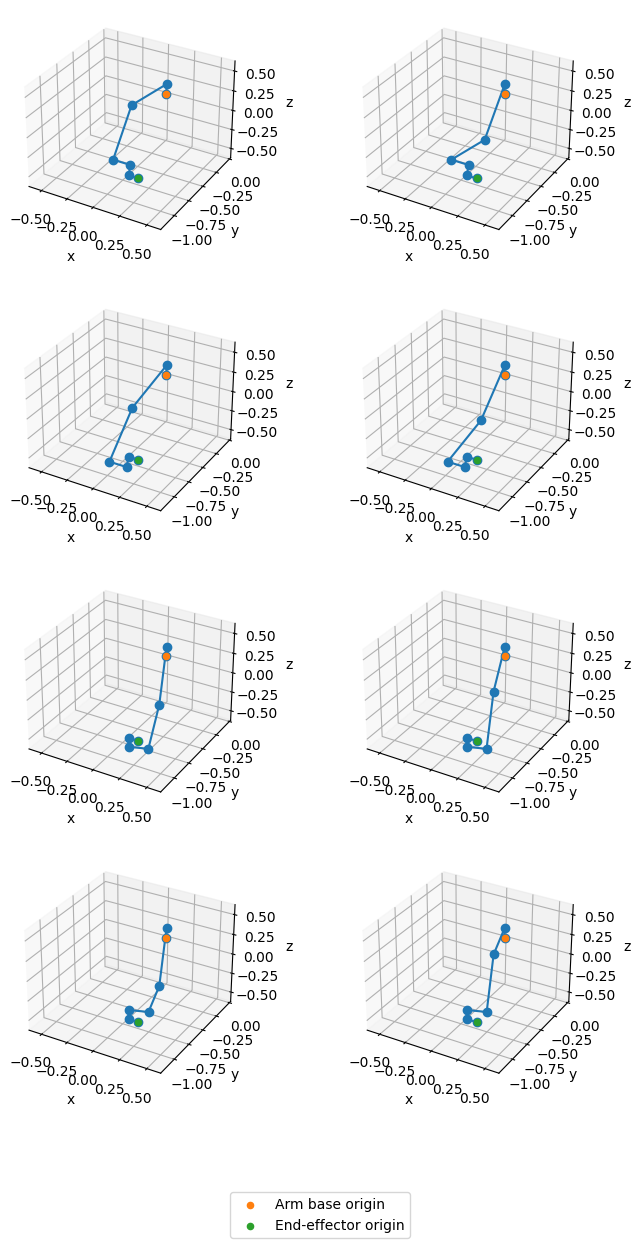

In [43]:
PlotSolutions(solutions)

## Singularities

Singularities happen when the determinant of the jacobian is 0. 

The jacobian of the ur10 can be found easily from the forward kinematics:
$$\boldsymbol{J}=\left[\begin{array}{l}
\boldsymbol{J}_{L_t} \\
\boldsymbol{J}_{A_t}
\end{array}\right]=\left[\begin{array}{c}
\boldsymbol{b}_{i} \times \boldsymbol{r}_{i, e} \\
\boldsymbol{b}_{i}
\end{array}\right]$$
where $\boldsymbol{b}_{i}$ is the z axis of frame i while $\boldsymbol{r}_{i, e}$ is the position of the end effector in frame i

The determinant is given by:
$$det(J)=s_3s_5a_2a_3(c_2a_2+c_{23}a_3+s_{234}d_5)$$

The determinant is zero when:
$$\theta_3 = 0, \pm \pi \\
\theta_5 = 0, \pm \pi \\
c_2a_2+c_{23}a_3+s_{234}d_5 = 0
$$
In general the robot is in a singular configuration when it is impossible to move the end-effector in atleast 1 direction.  
Source: https://www.mdpi.com/2218-6581/11/6/137